## Phone Data

In [5]:
import os
import statistics
import csv
import itertools
import keras
import sklearn.linear_model

import pandas as pd
import numpy as np
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sn

from tqdm import tqdm_notebook as tqdm
from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from keras.models import Sequential
from keras.layers import *
from keras.utils import to_categorical
from keras.optimizers import Adam

In [6]:
act_path = "wisdm-dataset/activity_key.txt"
act_file = open(act_path,"r")
act_list = act_file.read().split('\n')
act_map = {}
for elem in act_list:
    split = elem.split(" = ")
    if len(split) < 2:
        continue
    act_map[split[1]] = split[0]
#map of activies: Label : action    
act_map

{'A': 'walking',
 'B': 'jogging',
 'C': 'stairs',
 'D': 'sitting',
 'E': 'standing',
 'F': 'typing',
 'G': 'teeth',
 'H': 'soup',
 'I': 'chips',
 'J': 'pasta',
 'K': 'drinking',
 'L': 'sandwich',
 'M': 'kicking',
 'O': 'catch',
 'P': 'dribbling',
 'Q': 'writing',
 'R': 'clapping',
 'S': 'folding'}

In [7]:
phone = pd.read_pickle('phone.df')

In [8]:
window_size = 100
stride = window_size

frames = []
for i in tqdm(range(0, len(phone)-window_size, stride)):
    window = phone.iloc[i:i+window_size]
    if window['activity'].nunique() == 1:
        frames.append(window)

In [9]:
activities = sorted(act_map.keys())
activity_encoding = {v: k for k, v in enumerate(activities)}

X_list = []
y_list = []

#for each frame replace label with activity
for frame in tqdm(frames):
    X_list.append(frame[['phone_accel_x', 'phone_accel_y', 'phone_accel_z', 'phone_gyro_x', 'phone_gyro_y', 'phone_gyro_z']].values)
    y_list.append(activity_encoding[frame.iloc[0]['activity']])

In [10]:
X = np.array(X_list)
y = np.array(to_categorical(y_list))

In [11]:
print(X.shape)
print(y.shape)

(46906, 100, 6)
(46906, 18)


sandwich


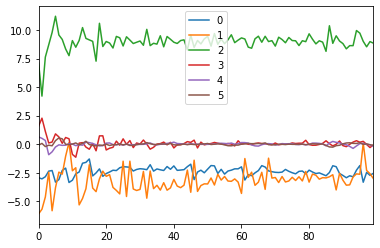

In [16]:
#six datapoints: phone 3 for accel x,y,z and gyros x,y,z data 
#example: xyz of accel for phone is 0 1 2 
#n is index into the dataframe of the X_list which is list of all of the windows
n = 16000
pd.DataFrame(X_list[n]).plot()

reverse_activity_encoding = {v: act_map[k] for k, v in activity_encoding.items()}
print(reverse_activity_encoding[y_list[n]])


In [19]:
#data split: as informed by slides split for 30,000 examples 
#our example is a window and coming from a big expansive amount of data
#5 second split based on papers using 5 sec split. We can play with this 

X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=42)

#train
print("X_train: ",X_train.shape)

#dev
print("X_val: ",X_val.shape)

#test
print("X_test: ",X_test.shape)

print("Y_train: ",y_train.shape)
print("Y_val: ",y_val.shape)
print("Y_test: ",y_test.shape)

X_train:  (28143, 100, 6)
X_val:  (9381, 100, 6)
X_test:  (9382, 100, 6)
Y_train:  (28143, 18)
Y_val:  (9381, 18)
Y_test:  (9382, 18)


In [20]:
#TEST out different data split 
#80% train 10% val 10% test

#data split: as informed by slides split for 30,000 examples 
#our example is a window and coming from a big expansive amount of data
#5 second split based on papers using 5 sec split. We can play with this 

X_train_new, X_valtest_new, y_train_new, y_valtest_new = train_test_split(X, y, test_size=0.2, random_state=42)
X_val_new, X_test_new, y_val_new, y_test_new = train_test_split(X_valtest_new, y_valtest_new, test_size=0.5, random_state=42)

#train
print("X_train_new: ",X_train_new.shape)

#dev
print("X_val_new: ",X_val_new.shape)

#test
print("X_test_new: ",X_test_new.shape)

print("Y_train_new: ",y_train_new.shape)
print("Y_val_new: ",y_val_new.shape)
print("Y_test_new: ",y_test_new.shape)

X_train_new:  (37524, 100, 6)
X_val_new:  (4691, 100, 6)
X_test_new:  (4691, 100, 6)
Y_train_new:  (37524, 18)
Y_val_new:  (4691, 18)
Y_test_new:  (4691, 18)


## LogReg Baseline

In [21]:
lrModel = sklearn.linear_model.LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')
X_train_flattened = X_train.reshape((X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
print("X: ",X_train_flattened.shape)
lrModel.fit(X_train_flattened, y_train.argmax(axis=1))

X:  (28143, 600)


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

In [22]:
lrModel_new = sklearn.linear_model.LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')
X_train_flattened_new = X_train_new.reshape((X_train_new.shape[0], X_train_new.shape[1] * X_train_new.shape[2]))
print("X2: ",X_train_flattened_new.shape)
lrModel_new.fit(X_train_flattened_new, y_train_new.argmax(axis=1))

X2:  (37524, 600)


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

In [23]:
#logreg results
predictions = lrModel.predict(X_val.reshape(X_val.shape[0], X_val.shape[1]*X_val.shape[2]))
score = lrModel.score(X_val.reshape(X_val.shape[0], X_val.shape[1]*X_val.shape[2]), y_val.argmax(axis=1))
print(score)

0.12013644600788828


In [24]:
#logreg results
predictions_new = lrModel_new.predict(X_val_new.reshape(X_val_new.shape[0], X_val_new.shape[1]*X_val_new.shape[2]))
score_new = lrModel_new.score(X_val_new.reshape(X_val_new.shape[0], X_val_new.shape[1]*X_val_new.shape[2]), y_val_new.argmax(axis=1))
print("2nd Data Split score: ", score_new)

2nd Data Split score:  0.11617991899381795


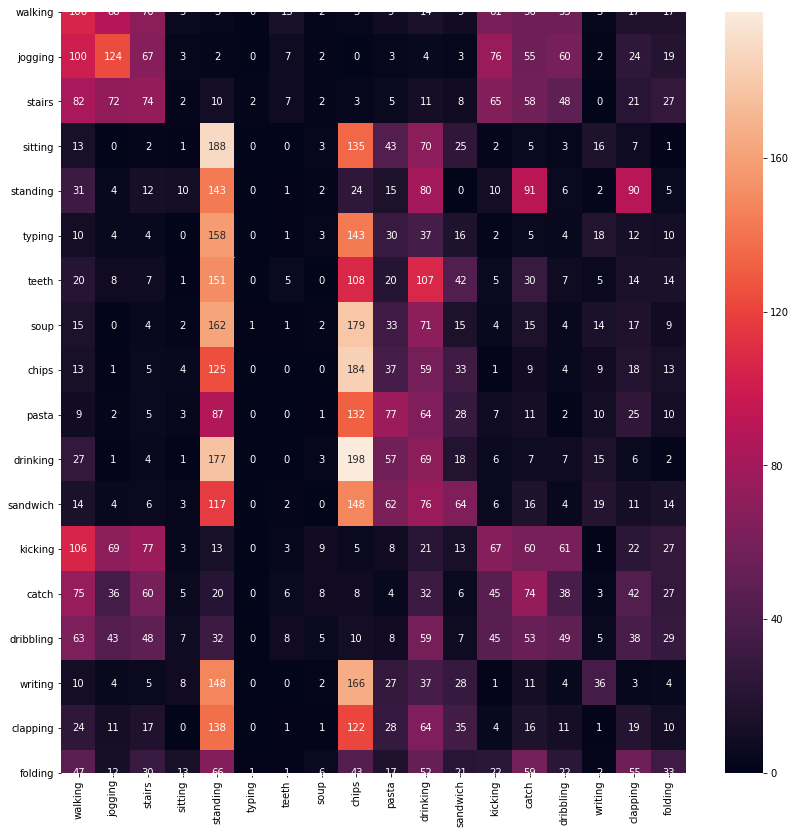

In [25]:
#As you can see: there's a locality of mispredictions around sports (kickingm catch, dribbling)
cm = confusion_matrix(y_val.argmax(axis=1), predictions)
df_cm = pd.DataFrame(cm, index = [reverse_activity_encoding[i] for i in range(18)], columns = [reverse_activity_encoding[i] for i in range(18)])
plt.figure(figsize = (14,14))
sn.heatmap(df_cm, annot=True, fmt='g')

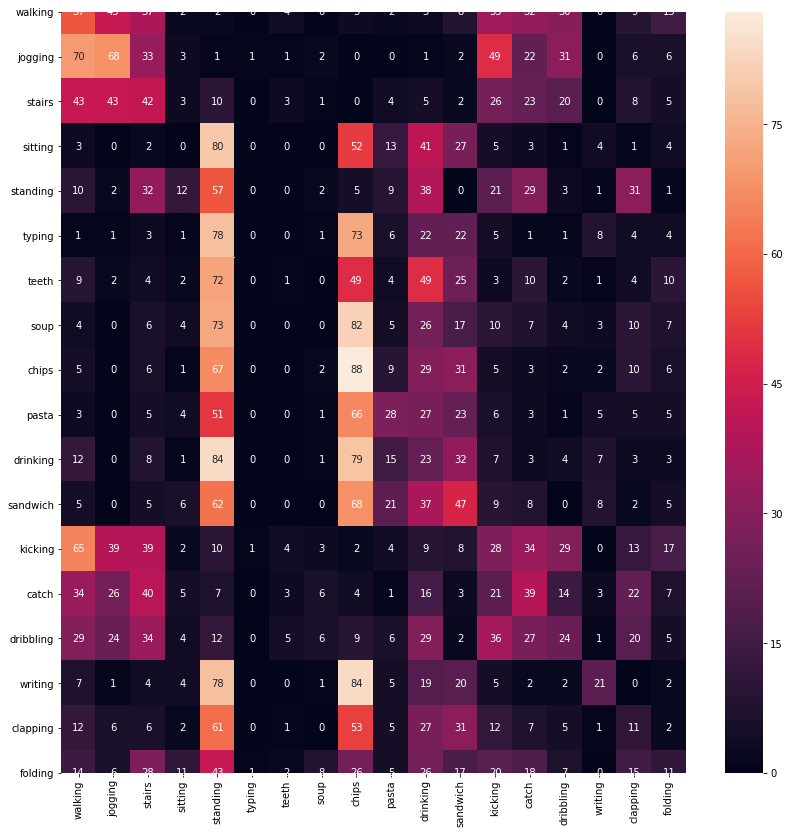

In [26]:
#As you can see: there's a locality of mispredictions around sports (kickingm catch, dribbling)
cm_new = confusion_matrix(y_val_new.argmax(axis=1), predictions_new)
df_cm_new = pd.DataFrame(cm_new, index = [reverse_activity_encoding[i] for i in range(18)], columns = [reverse_activity_encoding[i] for i in range(18)])
plt.figure(figsize = (14,14))
sn.heatmap(df_cm_new, annot=True, fmt='g')

In [27]:
#Model 

model = Sequential()

model.add(Conv1D(8, 3, activation='relu', input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(16, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

# keras.utils.plot_model(
#     model,
#     to_file='model_plot_4-ConvLayer.png',
#     show_shapes=True,
#     show_layer_names=True,
# )

model.summary()




Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 98, 8)             152       
_________________________________________________________________
batch_normalization_1 (Batch (None, 98, 8)             32        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 49, 8)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 47, 16)            400       
_________________________________________________________________
batch_normalization_2 (Batch (None, 47, 16)            64        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 23, 16)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 21, 32)          

In [28]:
#Model .8 /.1 /.1 Data  split

model_new = Sequential()

model_new.add(Conv1D(8, 3, activation='relu', input_shape=X_train_new.shape[1:]))
model_new.add(BatchNormalization())
model_new.add(MaxPooling1D(pool_size=2))

model_new.add(Conv1D(16, 3, activation='relu'))
model_new.add(BatchNormalization())
model_new.add(MaxPooling1D(pool_size=2))

model_new.add(Conv1D(32, 3, activation='relu'))
model_new.add(BatchNormalization())

model_new.add(MaxPooling1D(pool_size=2))

model_new.add(Conv1D(64, 3, activation='relu'))
model_new.add(BatchNormalization())
model_new.add(MaxPooling1D(pool_size=2))

model_new.add(Flatten())
model_new.add(Dense(128, activation='relu'))
model_new.add(Dense(y_train_new.shape[1], activation='softmax'))


model_new.summary()



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 98, 8)             152       
_________________________________________________________________
batch_normalization_5 (Batch (None, 98, 8)             32        
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 49, 8)             0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 47, 16)            400       
_________________________________________________________________
batch_normalization_6 (Batch (None, 47, 16)            64        
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 23, 16)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 21, 32)           

In [29]:
#loss function: using cross entropy
model.compile(Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['acc'])

In [30]:
#loss function: using cross entropy
model_new.compile(Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['acc'])

In [31]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), verbose=1)


Train on 28143 samples, validate on 9381 samples
Epoch 1/20
28143/28143 [==============================] - 18s 648us/step - loss: 2.1519 - acc: 0.2594 - val_loss: 1.9226 - val_acc: 0.3252
Epoch 2/20
28143/28143 [==============================] - 16s 552us/step - loss: 1.9118 - acc: 0.3238 - val_loss: 1.8195 - val_acc: 0.3554
Epoch 3/20
28143/28143 [==============================] - 15s 550us/step - loss: 1.8131 - acc: 0.3600 - val_loss: 1.7181 - val_acc: 0.3889
Epoch 4/20
28143/28143 [==============================] - 15s 551us/step - loss: 1.7413 - acc: 0.3823 - val_loss: 1.6840 - val_acc: 0.4080
Epoch 5/20
28143/28143 [==============================] - 15s 550us/step - loss: 1.6868 - acc: 0.4002 - val_loss: 1.6276 - val_acc: 0.4315
Epoch 6/20
28143/28143 [==============================] - 16s 569us/step - loss: 1.6361 - acc: 0.4212 - val_loss: 1.6164 - val_acc: 0.4233
Epoch 7/20
28143/28143 [==============================] - 16s 559us/step - loss: 1.5989 - acc: 0.4292 - val_loss: 1.

In [32]:
history_new = model_new.fit(X_train_new, y_train_new, epochs=20, validation_data=(X_val_new, y_val_new), verbose=1)

Train on 37524 samples, validate on 4691 samples
Epoch 1/20
37524/37524 [==============================] - 22s 577us/step - loss: 2.0926 - acc: 0.2778 - val_loss: 1.8376 - val_acc: 0.3453
Epoch 2/20
37524/37524 [==============================] - 19s 515us/step - loss: 1.8361 - acc: 0.3576 - val_loss: 1.6709 - val_acc: 0.4057
Epoch 3/20
37524/37524 [==============================] - 20s 522us/step - loss: 1.7343 - acc: 0.3905 - val_loss: 1.6254 - val_acc: 0.4257
Epoch 4/20
37524/37524 [==============================] - 20s 520us/step - loss: 1.6674 - acc: 0.4119 - val_loss: 1.5641 - val_acc: 0.4421
Epoch 5/20
37524/37524 [==============================] - 19s 507us/step - loss: 1.6139 - acc: 0.4304 - val_loss: 1.5176 - val_acc: 0.4741
Epoch 6/20
37524/37524 [==============================] - 19s 503us/step - loss: 1.5682 - acc: 0.4447 - val_loss: 1.4870 - val_acc: 0.4754
Epoch 7/20
37524/37524 [==============================] - 19s 510us/step - loss: 1.5257 - acc: 0.4585 - val_loss: 1.4

In [33]:
#Model 1 Epoch 20 loss: 1.3504 - acc: 0.5199 - val_loss: 1.4403 - val_acc: 0.4998

#Model 2 Epoch 20 loss: 1.2735 - acc: 0.5440 - val_loss: 1.2812 - val_acc: 0.5547

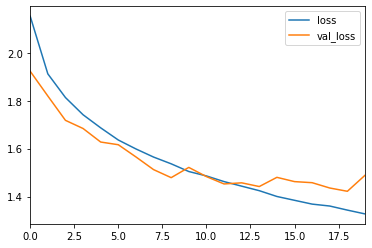

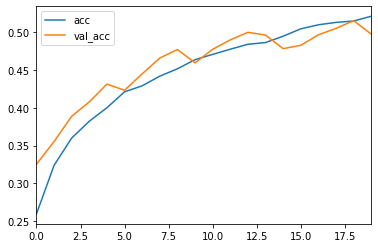

In [34]:
metrics_history = pd.DataFrame(history.history)
metrics_history[['loss', 'val_loss']].plot() #loss = train loss, val_loss = validation Loss
metrics_history[['acc', 'val_acc']].plot() # acc = train acc, val_acc = validation acc

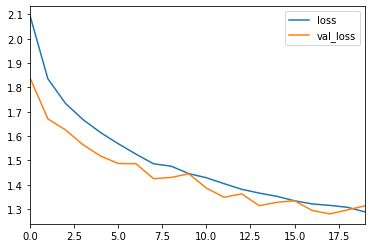

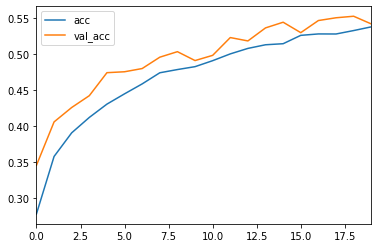

In [35]:
metrics_history_new = pd.DataFrame(history_new.history)
metrics_history_new[['loss', 'val_loss']].plot() #loss = train loss, val_loss = validation Loss
metrics_history_new[['acc', 'val_acc']].plot() # acc = train acc, val_acc = validation acc

In [36]:
y_val_pred = model.predict(X_val)

y_val_argmax = y_val.argmax(axis=1)
y_val_pred_argmax = y_val_pred.argmax(axis=1)

actual_val_activities = [reverse_activity_encoding[i] for i in y_val_argmax]
predicted_val_activities = [reverse_activity_encoding[i] for i in y_val_pred_argmax]

In [37]:
y_val_pred_new = model_new.predict(X_val_new)

y_val_argmax_new = y_val_new.argmax(axis=1)
y_val_pred_argmax_new = y_val_pred_new.argmax(axis=1)

actual_val_activities_new = [reverse_activity_encoding[i] for i in y_val_argmax_new]
predicted_val_activities_new = [reverse_activity_encoding[i] for i in y_val_pred_argmax_new]

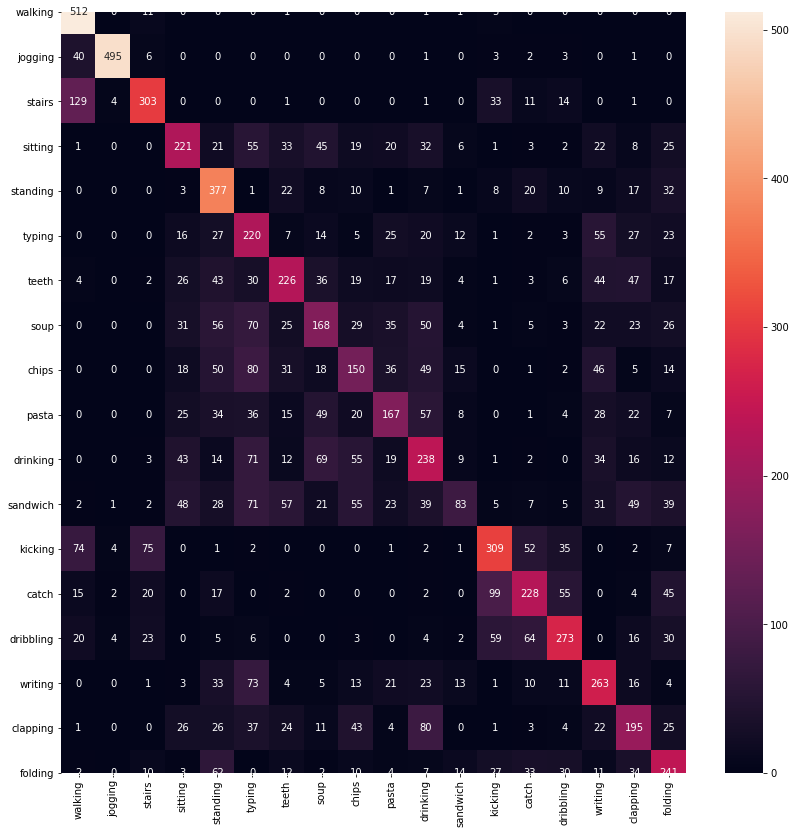

In [38]:
cm = confusion_matrix(y_val_argmax, y_val_pred_argmax)
df_cm = pd.DataFrame(cm, index = [reverse_activity_encoding[i] for i in range(18)], columns = [reverse_activity_encoding[i] for i in range(18)])
plt.figure(figsize = (14,14))
sn.heatmap(df_cm, annot=True, fmt='g')

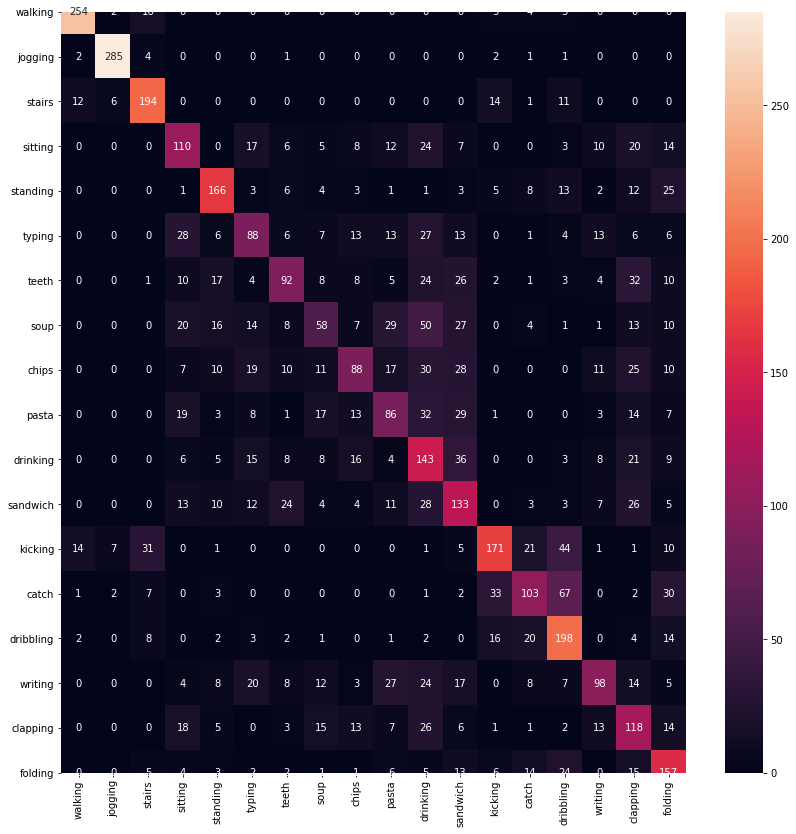

In [39]:
cm_new = confusion_matrix(y_val_argmax_new, y_val_pred_argmax_new)
df_cm_new = pd.DataFrame(cm_new, index = [reverse_activity_encoding[i] for i in range(18)], columns = [reverse_activity_encoding[i] for i in range(18)])
plt.figure(figsize = (14,14))
sn.heatmap(df_cm_new, annot=True, fmt='g')

In [40]:
#5 layer network NEW MODEL 

In [41]:
#Model .8 /.1 /.1 Data  split

model_five = Sequential()

model_five.add(Conv1D(8, 3, activation='relu', input_shape=X_train_new.shape[1:]))
model_five.add(BatchNormalization())
model_five.add(MaxPooling1D(pool_size=2))

model_five.add(Conv1D(16, 3, activation='relu'))
model_five.add(BatchNormalization())
model_five.add(MaxPooling1D(pool_size=2))

model_five.add(Conv1D(32, 3, activation='relu'))
model_five.add(BatchNormalization())
model_five.add(MaxPooling1D(pool_size=2))

model_five.add(Conv1D(64, 3, activation='relu'))
model_five.add(BatchNormalization())
model_five.add(MaxPooling1D(pool_size=2))

model_five.add(Conv1D(128, 3, activation='relu'))
model_five.add(BatchNormalization())
model_five.add(MaxPooling1D(pool_size=2))

model_five.add(Flatten())
model_five.add(Dense(256, activation='relu'))
model_five.add(Dense(y_train_new.shape[1], activation='softmax'))

model_five.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 98, 8)             152       
_________________________________________________________________
batch_normalization_9 (Batch (None, 98, 8)             32        
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 49, 8)             0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 47, 16)            400       
_________________________________________________________________
batch_normalization_10 (Batc (None, 47, 16)            64        
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 23, 16)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 21, 32)           

In [42]:
#loss function: using cross entropy
model_five.compile(Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['acc'])

In [43]:
history_five = model_five.fit(X_train_new, y_train_new, epochs=20, validation_data=(X_val_new, y_val_new), verbose=1)

Train on 37524 samples, validate on 4691 samples
Epoch 1/20
37524/37524 [==============================] - 31s 816us/step - loss: 2.0735 - acc: 0.2762 - val_loss: 1.7962 - val_acc: 0.3656
Epoch 2/20
37524/37524 [==============================] - 24s 634us/step - loss: 1.8355 - acc: 0.3525 - val_loss: 1.6814 - val_acc: 0.4093
Epoch 3/20
37524/37524 [==============================] - 23s 609us/step - loss: 1.7347 - acc: 0.3831 - val_loss: 1.6063 - val_acc: 0.4308
Epoch 4/20
37524/37524 [==============================] - 23s 616us/step - loss: 1.6601 - acc: 0.4122 - val_loss: 1.5801 - val_acc: 0.4440
Epoch 5/20
37524/37524 [==============================] - 24s 632us/step - loss: 1.6104 - acc: 0.4254 - val_loss: 1.4943 - val_acc: 0.4779
Epoch 6/20
37524/37524 [==============================] - 24s 628us/step - loss: 1.5599 - acc: 0.4464 - val_loss: 1.4662 - val_acc: 0.4807
Epoch 7/20
37524/37524 [==============================] - 24s 635us/step - loss: 1.5079 - acc: 0.4611 - val_loss: 1.4

In [44]:
#Model 1: 4 layers Data Split .6 / .2/ .2 Epoch 20 loss: 1.3504 - acc: 0.5199 - val_loss: 1.4403 - val_acc: 0.4998

#Model 2: 4 layers Data Split .8 / .1/ .1 Epoch 20 loss: 1.2735 - acc: 0.5440 - val_loss: 1.2812 - val_acc: 0.5547

#Model 3: 5 layers Data Split .8 / .1/ .1 Epoch 20 loss: 1.2066 - acc: 0.5616 - val_loss: 1.2266 - val_acc: 0.5881

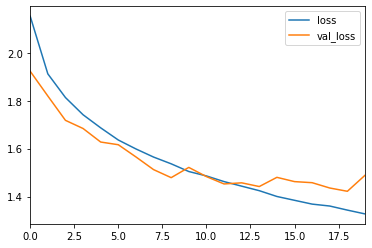

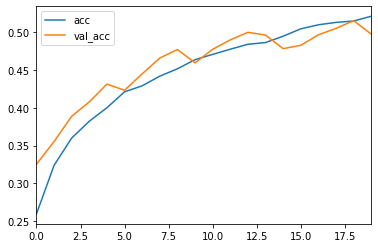

In [45]:
metrics_history = pd.DataFrame(history.history)
metrics_history[['loss', 'val_loss']].plot() #loss = train loss, val_loss = validation Loss
metrics_history[['acc', 'val_acc']].plot() # acc = train acc, val_acc = validation acc

In [46]:
y_val_pred_new = model_new.predict(X_val_new)

y_val_argmax_new = y_val_new.argmax(axis=1)
y_val_pred_argmax_new = y_val_pred_new.argmax(axis=1)

actual_val_activities_new = [reverse_activity_encoding[i] for i in y_val_argmax_new]
predicted_val_activities_new = [reverse_activity_encoding[i] for i in y_val_pred_argmax_new]

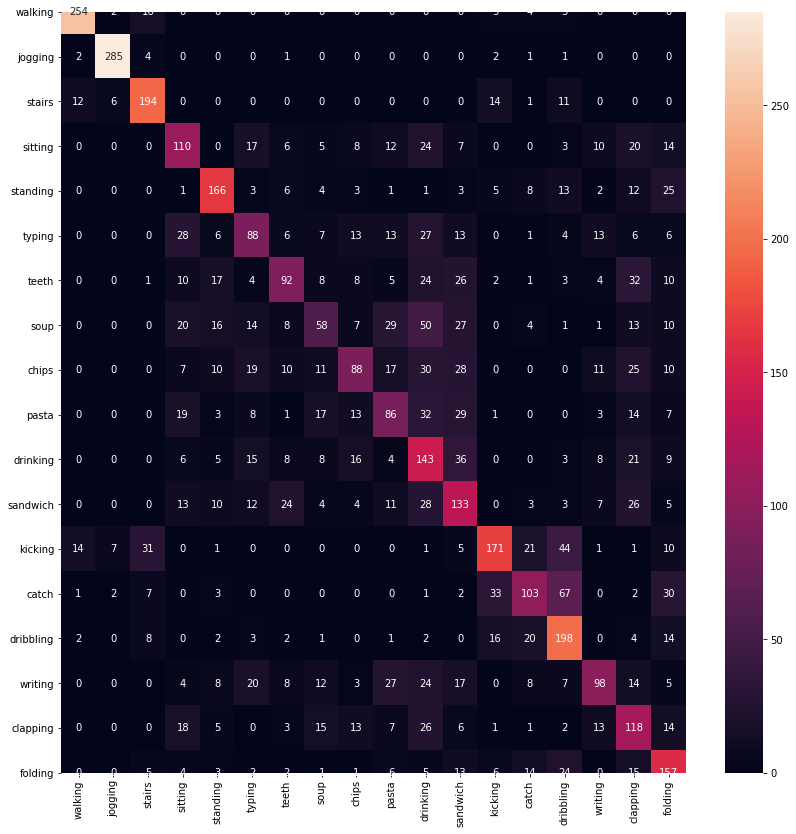

In [47]:
cm_new = confusion_matrix(y_val_argmax_new, y_val_pred_argmax_new)
df_cm_new = pd.DataFrame(cm_new, index = [reverse_activity_encoding[i] for i in range(18)], columns = [reverse_activity_encoding[i] for i in range(18)])
plt.figure(figsize = (14,14))
sn.heatmap(df_cm_new, annot=True, fmt='g')

## LSTM 


In [49]:
#return_sequences is true bc we sliced data
lstmModel = Sequential()
lstmModel.add(LSTM(64, return_sequences=True, input_shape=X_train.shape[1:]))
lstmModel.add(LSTM(64))
lstmModel.add(Dense(y_train.shape[1], activation='softmax'))


In [50]:
lstmModel.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 64)           18176     
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_8 (Dense)              (None, 18)                1170      
Total params: 52,370
Trainable params: 52,370
Non-trainable params: 0
_________________________________________________________________


In [51]:
#loss function: using cross entropy
lstmModel.compile(Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['acc'])

In [52]:
lstm_history = lstmModel.fit(X_train_new, y_train_new, epochs=20, validation_data=(X_val_new, y_val_new), verbose=1)

Train on 37524 samples, validate on 4691 samples
Epoch 1/20
37524/37524 [==============================] - 280s 7ms/step - loss: 2.1963 - acc: 0.2478 - val_loss: 1.9585 - val_acc: 0.2991
Epoch 2/20
37524/37524 [==============================] - 270s 7ms/step - loss: 1.8861 - acc: 0.3411 - val_loss: 1.8162 - val_acc: 0.3658
Epoch 3/20
37524/37524 [==============================] - 274s 7ms/step - loss: 1.7764 - acc: 0.3782 - val_loss: 1.7191 - val_acc: 0.4012
Epoch 4/20
37524/37524 [==============================] - 271s 7ms/step - loss: 1.6793 - acc: 0.4138 - val_loss: 1.6347 - val_acc: 0.4283
Epoch 5/20
37524/37524 [==============================] - 276s 7ms/step - loss: 1.5981 - acc: 0.4421 - val_loss: 1.5718 - val_acc: 0.4387
Epoch 6/20
37524/37524 [==============================] - 263s 7ms/step - loss: 1.5332 - acc: 0.4700 - val_loss: 1.5449 - val_acc: 0.4534
Epoch 7/20
37524/37524 [==============================] - 280s 7ms/step - loss: 1.4531 - acc: 0.4962 - val_loss: 1.4485 - v

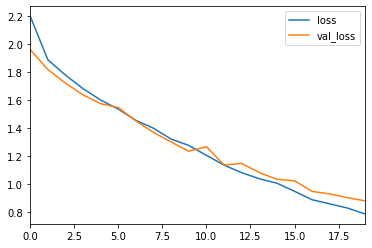

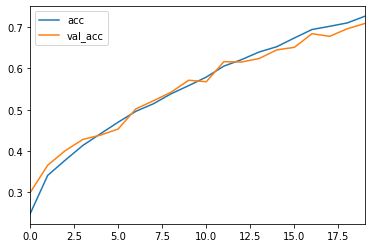

In [53]:
metrics_history = pd.DataFrame(lstm_history.history)
metrics_history[['loss', 'val_loss']].plot() #loss = train loss, val_loss = validation Loss
metrics_history[['acc', 'val_acc']].plot() # acc = train acc, val_acc = validation acc

In [54]:
#Model 1: 4 layers Data Split .6 / .2/ .2 Epoch 20 loss: 1.3504 - acc: 0.5199 - val_loss: 1.4403 - val_acc: 0.4998

#Model 2: 4 layers Data Split .8 / .1/ .1 Epoch 20 loss: 1.2735 - acc: 0.5440 - val_loss: 1.2812 - val_acc: 0.5547

#Model 3: 5 layers Data Split .8 / .1/ .1 Epoch 20 loss: 1.2066 - acc: 0.5616 - val_loss: 1.2266 - val_acc: 0.5881

#LSTM 2-layer stacked model Epoch 20/20 loss: 0.7854 - acc: 0.7265 - val_loss: 0.8785 - val_acc: 0.7090